In [1]:
from collections import defaultdict
import re
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [2]:
genete_annot = pd.read_csv('../data/gffs/danRer11.nonalt.genes_tes.gtf', sep='\t', header=None)
genete_annot['len'] = abs(genete_annot[3] - genete_annot[4])
genete_annot['gene'] = genete_annot[8].apply(lambda x: x.split()[3].strip(';').strip('"'))
genelengths = genete_annot[['gene', 'len']] \
    .groupby('gene') \
    .sum() \
    .reset_index()
genelengths = dict(zip(genelengths['gene'], genelengths['len']))

/Users/jonwells/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
sample_df = pd.read_csv('../data/expression/White2017/elife-30860-supp1-v1.tsv', sep='\t')
sample_df = sample_df.rename({'accession_number': 'sampleAccession'}, axis=1)
print(sample_df)

           sample                public_name sampleAccession    condition  \
0     zmp_ph133_B        ZMP_phenotype_133_B      ERS1079239  ZFS:0000001   
1     zmp_ph133_D        ZMP_phenotype_133_D      ERS1079240  ZFS:0000001   
2     zmp_ph133_E        ZMP_phenotype_133_E      ERS1079241  ZFS:0000001   
3     zmp_ph133_F        ZMP_phenotype_133_F      ERS1079243  ZFS:0000001   
4     zmp_ph133_G        ZMP_phenotype_133_G      ERS1079244  ZFS:0000001   
..            ...                        ...             ...          ...   
508  zmp_ph122_E5  ZMP_phenotype_122_5dpf_E5       ERS626209  ZFS:0000037   
509  zmp_ph122_E6  ZMP_phenotype_122_5dpf_E6       ERS626210  ZFS:0000037   
510  zmp_ph122_E7  ZMP_phenotype_122_5dpf_E7       ERS626211  ZFS:0000037   
511  zmp_ph122_E8  ZMP_phenotype_122_5dpf_E8       ERS626212  ZFS:0000037   
512  zmp_ph122_E9  ZMP_phenotype_122_5dpf_E9       ERS626213  ZFS:0000037   

             stage stageName             sampleName sequencing  
0    Zygot

In [9]:
def calc_tpm(tecountsfile):
    accession = re.search('(ERS\d+)\.', tecountsfile).group(1)
    tecount_df = pd.read_csv(tecountsfile, skiprows=1, header=None, names=['gene', 'reads'], sep='\t')
#     ascale = sum(tecount_df['reads'])/1000000
    tecount_df['gene'] = tecount_df['gene'].apply(lambda x: x.split(':')[0])
#     tecount_df['len'] = tecount_df['gene'].apply(lambda x: genelengths[x])
#     tecount_df['rpk'] = tecount_df['reads']/tecount_df['len']
#     tecount_df[accession] = tecount_df['rpk']/ascale
    tecount_df[accession] = tecount_df.reads
    return tecount_df[['gene', accession]]

accessions = {}
with open('../data/expression/White2017/sample_list.txt') as infile:
    accessions = {line.split()[0]: line.split()[1:] for line in infile}

tpm_df = pd.DataFrame({'gene': list(genelengths.keys())}).sort_values('gene')
for acc in accessions.keys():
    acc_df = calc_tpm(f'../data/expression/TEcount-out/{acc}.cntTable').sort_values('gene')
    tpm_df[acc] = acc_df[acc]

print(tpm_df.head())
# tpm_df.to_csv('../data/expression/white2017_remapped_tpm.txt', sep='\t', header=True, index=False)

       gene  ERS1079138  ERS1079139  ERS1079140  ERS1079141  ERS1079142  \
0  (CATTC)n           3           0           0           0           2   
1  (GAATG)n           2           1           1           0           1   
2  ACROBAT1           5           0           4           5           0   
3  ACROBAT2           0           1           2           1           1   
4     ANGEL           3           4           4           0           0   

   ERS1079143  ERS1079144  ERS1079145  ERS1079146  ...  ERS1079233  \
0          18           9          16          13  ...           4   
1           1           1           3           0  ...           6   
2           1           1           2           1  ...           9   
3           0           1           0           0  ...           7   
4           0           1           1           0  ...           2   

   ERS1079234  ERS1079235  ERS1079236  ERS1079238  ERS1079239  ERS1079240  \
0           4           1           1           0  

In [16]:
melted_tpm_df = tpm_df.melt(id_vars='gene', var_name='sampleAccession', value_name='reads')
# melted_tpm_df['sampleAccession'] = melted_tpm_df['readAccession'].apply(accessions.get)
melted_tpm_df = melted_tpm_df.merge(sample_df[['sampleAccession', 'stageName', 'sequencing']], on='sampleAccession', how='left')
melted_tpm_df = melted_tpm_df.loc[melted_tpm_df.sequencing == 'RNASeq']


In [17]:
stageorder = ['1-cell', 
             '2-cell', 
             '128-cell', 
             '1k-cell', 
             'Dome', 
             '50pc-epiboly', 
             'Shield', 
             '75pc-epiboly', 
             '1-4-somites', 
             '14-19-somites', 
             '20-25-somites',
             'Prim-5',
             'Prim-15',
             'Prim-25',
             'Long-pec',
             'Protruding-mouth',
             'Day-4',
             'Day-5']
melted_tpm_df['stageName'] = pd.Categorical(melted_tpm_df['stageName'], stageorder)
melted_tpm_df = melted_tpm_df.sort_values('stageName')

In [18]:
test = melted_tpm_df.groupby(['gene'], as_index=False).max()
expressed = test.loc[(test.reads > 100) & (test.gene.str.startswith('g')), 'gene'].to_list()
print(expressed)

['g1003', 'g1007', 'g101', 'g1013', 'g1019', 'g1063', 'g1064', 'g1065', 'g1066', 'g1067', 'g1075', 'g1080', 'g1081', 'g1087', 'g1091', 'g1092', 'g1095', 'g1119', 'g1120', 'g1129', 'g1139', 'g1140', 'g1141', 'g1143', 'g1148', 'g1194', 'g1195', 'g1196', 'g1198', 'g120', 'g1205', 'g1221', 'g1222', 'g127', 'g1272', 'g1276', 'g1286', 'g1293', 'g13', 'g1308', 'g1318', 'g1330', 'g1331', 'g1337', 'g1344', 'g1348', 'g1355', 'g1356', 'g1358', 'g1383', 'g1385', 'g1395', 'g1400', 'g1422', 'g1423', 'g1427', 'g1431', 'g1432', 'g1439', 'g144', 'g1440', 'g1448', 'g1454', 'g1458', 'g1460', 'g1461', 'g1488', 'g1512', 'g1520', 'g1521', 'g1535', 'g1549', 'g155', 'g1570', 'g1575', 'g1590', 'g1607', 'g1614', 'g1669', 'g1676', 'g1677', 'g1686', 'g1785', 'g1797', 'g1807', 'g1821', 'g1831', 'g1853', 'g1866', 'g1867', 'g1868', 'g1871', 'g1872', 'g1882', 'g189', 'g1901', 'g1906', 'g192', 'g1928', 'g193', 'g1944', 'g1945', 'g1946', 'g195', 'g1960', 'g1978', 'g2014', 'g2016', 'g2021', 'g2025', 'g203', 'g2036', 'g2

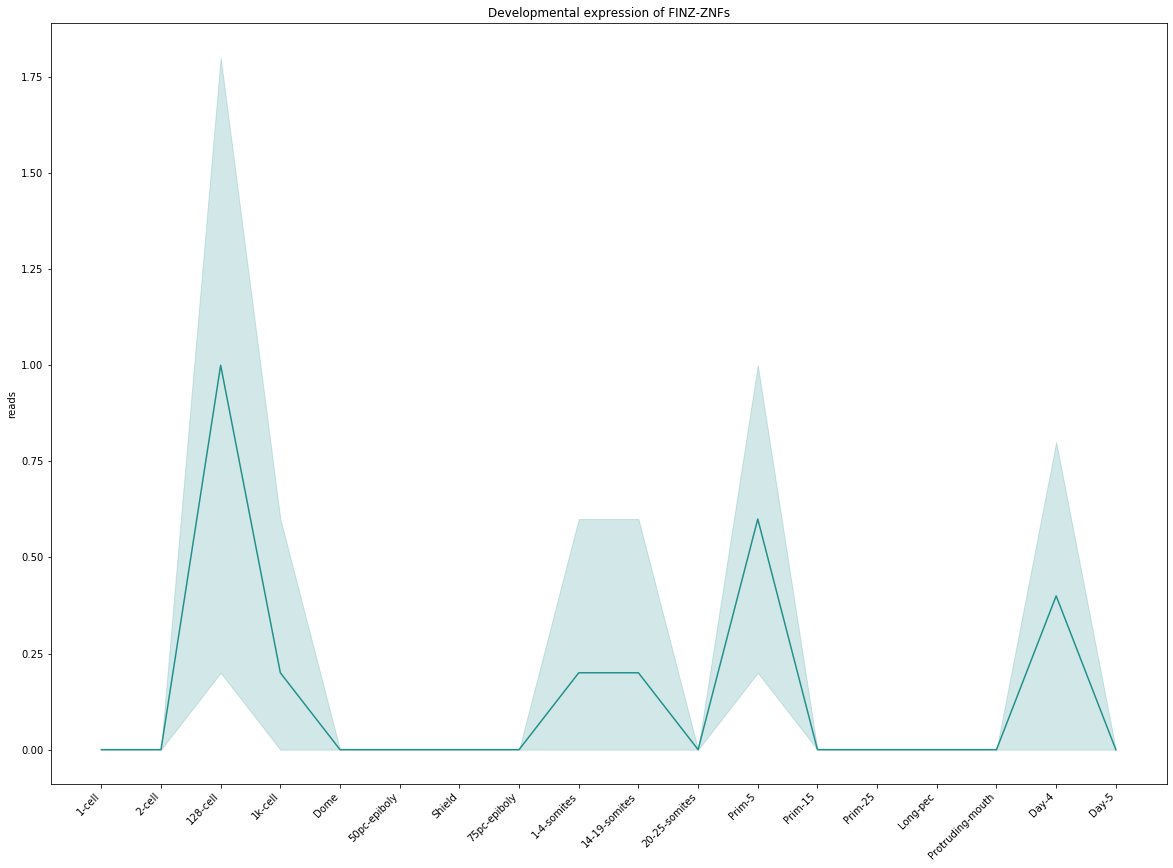

In [21]:
with open('../data/expression/expressed.names') as infile:
    expressed = [line.strip() for line in infile]

fig, ax = plt.subplots(figsize=(20, 14))

sns.lineplot(data=melted_tpm_df.loc[melted_tpm_df.gene == 'BHIKHARI_LTR'],
             x='stageName', 
             y='reads', 
             sort=False,
             hue='gene',
             palette='viridis_r',
             ax=ax)
ax.set_title('Developmental expression of FINZ-ZNFs')
ax.get_legend().remove()
ax.set_xlabel('')
plt.xticks(rotation=45, ha='right')
plt.show()
# # axins = inset_axes(ax, width=3, height=2)
# # axins.tick_params(labelleft=True, labelbottom=False)

# # box_hue_order = melted_expression_df.loc[melted_expression_df['Gene ID'].isin(finz_znfs)] \
# #     .groupby('Stage') \
# #     .median() \
# #     .reset_index() \
# #     .sort_values('TPM+1')['Stage'] \
# #     .to_list()

# # sns.boxplot(data=melted_expression_df.loc[melted_expression_df['Gene ID'].isin(finz_znfs)],
# #             x='Stage',
# #             y='TPM+1',
# #             hue='Stage',
# #             dodge=False,
# #             palette='viridis', 
# #             hue_order=box_hue_order,
# #             ax=axins)
# # axins.set_yscale('log')
# # axins.get_legend().remove()
# # plt.xticks(rotation=45, ha='right')

# # sns.despine()
# # plt.show()

# # fig.savefig('/Users/jonwells/Desktop/znf_expression.pdf', bbox_inches='tight')

KeyboardInterrupt: 

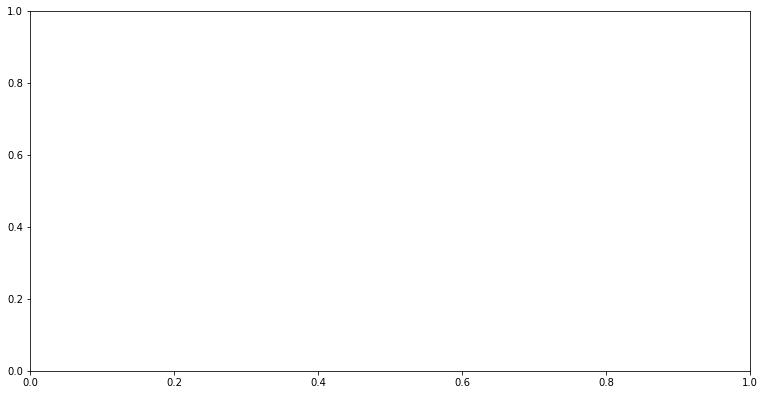

In [20]:
fig, ax = plt.subplots(figsize=(10, 5))
ax2 = plt.axes([0,0,1,1])


sns.boxplot(data=melted_tpm_df.loc[(melted_tpm_df['gene'].isin(expressed)) & (melted_tpm_df.groupby(['gene', 'stageName']))],
            x='stageName',
            y='reads',
            palette='viridis', ax=ax2)
ax.set_yscale('log')
plt.xticks(rotation=45, ha='right')
plt.show()

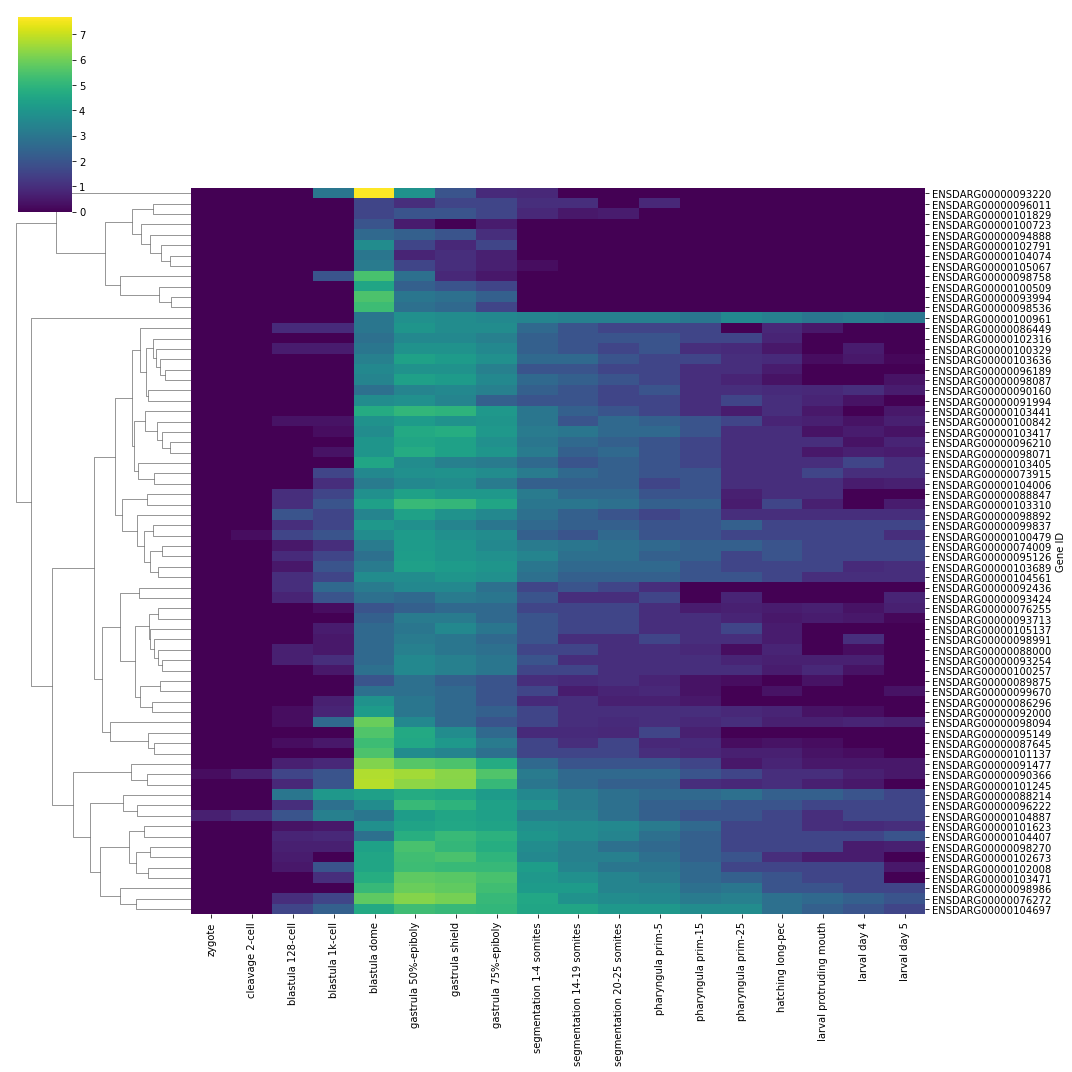

In [7]:
finz_matrix = expression_df.loc[expression_df['Gene ID'].isin(finz_znfs)].drop('Gene Name', axis=1).set_index('Gene ID')
finz_matrix = np.log2(finz_matrix + 1)

# fig, ax = plt.subplots(figsize=(15, 10))
sns.clustermap(data=finz_matrix, cmap="viridis", col_cluster=False, figsize=(15,15), yticklabels=True)
plt.show()

In [8]:
def avg_replicates(df):
    stages = defaultdict(list)
    for col in df.columns[1:]:
        stage = '_'.join(col.split('_')[:-2])
        stages[stage].append(col)
    for stage in stages:
        df[stage] = df[stages[stage]].median(axis=1)
        df = df.drop(stages[stage], axis=1)
    return df

In [9]:
df_genes_norm = pd.read_csv('../data/expression/counts_Genes_norm.tab',
                            sep='\t')
df_genes_norm = avg_replicates(df_genes_norm)
melted_genes = df_genes_norm.melt(id_vars='Genes', var_name='stage', value_name='norm_counts')
melted_genes['type'] = 'gene'

df_tes_norm = pd.read_csv('../data/expression/counts_TE_loci_norm.tab',
                            sep='\t')
df_tes_norm = avg_replicates(df_tes_norm)
df_tes_norm['TEs'] = df_tes_norm['TEs'].apply(lambda x: re.sub('_dup\d.*', '', x))
df_tes_norm = df_tes_norm.groupby('TEs').sum().reset_index()
melted_tes = df_tes_norm.melt(id_vars='TEs', var_name='stage', value_name='norm_counts')
melted_tes = melted_tes.rename({'TEs': 'Genes'}, axis=1)
melted_tes['type'] = 'te'

expression_df2 = pd.concat([melted_tes, melted_genes], ignore_index=True)
print(expression_df2.head())

           Genes   stage   norm_counts type
0       ACROBAT1  1_cell      2.378126   te
1       ACROBAT2  1_cell     42.384083   te
2          ANGEL  1_cell  10879.436503   te
3    Academ-1_DR  1_cell      0.000000   te
4  Academ-N1_DRe  1_cell    171.169842   te


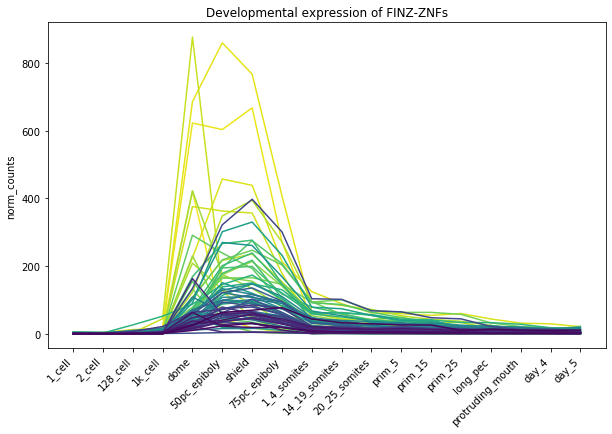

In [10]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=melted_genes.loc[melted_genes['Genes'].isin(finz_znfs)],
             x='stage', 
             y='norm_counts', 
             hue='Genes',
             sort=False,
             palette='viridis_r',
             hue_order=hue_order[::-1],
             ax=ax)
ax.set_title('Developmental expression of FINZ-ZNFs')
ax.get_legend().remove()
ax.set_xlabel('')
plt.xticks(rotation=45, ha='right')
plt.show()
